In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
%time data = pd.read_csv('dataset/dataset_no_2018.csv', encoding='cp1251')
data.head()

CPU times: user 48.6 s, sys: 2.9 s, total: 51.5 s
Wall time: 51.6 s


,Unnamed: 0,date,RF.21304.Ток...213MII904A,S.C.ВПУСК.ПП.ДАВЛ...214PI226AA,S.C.ВПУСК.ПП.ДАВЛ...214PI226AB,S.C.ВПУСК.ПП.ТЕМП...214TI232A,SPEED.CONTROLLER...250MSIC001.PV,XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV,ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A,ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981,...,ЦИЛ..3.ТЕМП.УПР...214TIC207A,ЦИЛ..4.ТЕМП.УПР...214TIC208A,ЦИЛ..5.ТЕМП.УПР...214TIC209A,ЦИЛ..6.ТЕМП.УПР...214TIC210A,ЦИЛ..7.ТЕМП.УПР...214TIC211A,ЦИЛ..8.ТЕМП.УПР...214TIC212A,ЦИЛ..9.ТЕМП.УПР...214TIC213A,ЭКСТР.ДВИГ.ВЛАСТЬ...214JI200A,ЭКСТР.ДВИГ.ПОТОК...214II200A,H2.C3..КОНТР.СООТН...212AIC008.PV
0,0,2017-01-01 00:00:10,NaN,14.880000,14.860000,256.100006,0.0,NaN,0.5277,NaN,...,153.300003,240.100006,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
1,1,2017-01-01 00:00:20,NaN,14.880000,14.839999,256.000000,0.0,NaN,0.5277,NaN,...,153.300003,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
2,2,2017-01-01 00:00:30,NaN,14.870000,14.820000,256.000000,0.0,NaN,0.5277,NaN,...,153.400009,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
3,3,2017-01-01 00:00:40,NaN,14.889999,14.870000,256.100006,0.0,NaN,0.5277,NaN,...,153.400009,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN
4,4,2017-01-01 00:00:50,NaN,14.880000,14.830000,256.100006,0.0,NaN,0.5277,NaN,...,153.400009,240.199997,234.900009,225.0,220.0,220.300003,220.100006,5890.0,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3153599 entries, 0 to 3153598
Data columns (total 45 columns):
Unnamed: 0                                 int64
date                                       object
RF.21304.Ток...213MII904A                  float64
S.C.ВПУСК.ПП.ДАВЛ...214PI226AA             float64
S.C.ВПУСК.ПП.ДАВЛ...214PI226AB             float64
S.C.ВПУСК.ПП.ТЕМП...214TI232A              float64
SPEED.CONTROLLER...250MSIC001.PV           float64
XX21401.МАСС.РАСХ.ГРАНУЛ...214FIC112.PV    float64
ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A             float64
ДВИГАТЕЛЬ.ГРАНУЛЯТОРА...214MSIC981         float64
Е.21402А....ГР.ВОДА.ВЫХ...214TIC101A       float64
ЕХ21401.АЕ01.MFR...214AI200A               float64
НАГНЕТАНИЕ.В.EX.21401...250PI001           float64
ПОЛОЖ.НОЖА..ГРАНУЛЯТОРА...214ZI211A        float64
ПОЛОЖ.ЩЕЛ.ДИСКА...214ZI202A                float64
РАСХОД.В....EX.21401...250FIC001.PV        float64
РАСХОД.ЛИНИИ.P.W...214FI205A               float64
СЕКТ.ПИТАТЕЛЬ.RF21304..

In [6]:
import tqdm
import numpy as np
import pandas as pd
import lightgbm as lgb

from dateutil import parser
from sklearn.metrics import f1_score
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold

np.random.seed(4242)

In [7]:
%time df = pd.read_csv('dataset/dataset_no_2018.csv', encoding='cp1251', parse_dates=['date'])
df.drop('Unnamed: 0', axis=1, inplace=True)
stops = pd.read_csv('dataset/stops.csv', parse_dates=['date'])
df.shape, stops.shape

CPU times: user 52.6 s, sys: 2.4 s, total: 55 s
Wall time: 55.1 s


((3153599, 44), (47, 2))

In [8]:
def make_features(df, periods=[1, 3, 10, 30, 50]):  # < M_TOP_BOUND_SPAN = 10 min
    columns = df.columns[df.columns != 'date']
    names = []
    vecs = []
    for period in periods:
        feats = [
            ('mean', df[-period:][columns].mean(axis=0).values),
            ('min', df[-period:][columns].min(axis=0).values),
            ('std', df[-period:][columns].std(axis=0).values),
            ('razd', df[-period - 1:][columns].diff().mean(axis=0).values)
        ]
        
        fs = []
        for f_name, f in feats:
            names.extend(f'{f_name}_{c}_{period}' for c in columns)
            fs.append(f)
        
        vecs.append(np.hstack(fs))
    
    return names, np.hstack(vecs)


NAMES = make_features(df)[0]

In [13]:
import torch

In [14]:
torch.save(NAMES, 'sasha.pt')

In [15]:
import pickle

In [27]:
pickle.dump(NAMES, open('sasha.pt', 'wb'))

In [28]:
pickle.load(open('sasha.pt', 'rb'))

['mean_RF.21304.Ток...213MII904A_1',
 'mean_S.C.ВПУСК.ПП.ДАВЛ...214PI226AA_1',
 'mean_S.C.ВПУСК.ПП.ДАВЛ...214PI226AB_1',
 'mean_S.C.ВПУСК.ПП.ТЕМП...214TI232A_1']

In [21]:
pickle.load(open('sasha.pt', 'r', encoding='utf-16'))[:4]

UnicodeError: UTF-16 stream does not start with BOM

In [12]:
with open('sasha.txt', 'w', encoding='utf-16') as f:
    f.write('[')
    for i, n in enumerate(NAMES):
        if i == len(NAMES):
            f.write(f"'{n}'")
        else:
            f.write(f"'{n}', ")
    f.write(']')

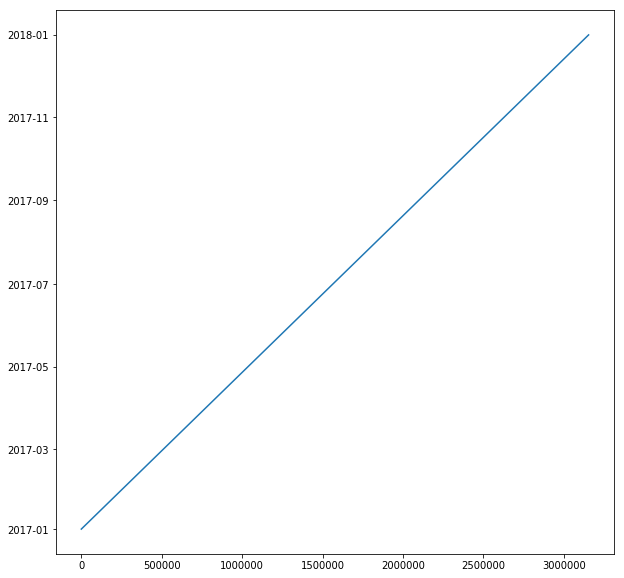

In [13]:
dates = pd.to_datetime(data.date)
# dates = dates.sort_values()
plt.figure(figsize=(10, 10))
dates.plot();

In [49]:
%time corr = data.corr()

CPU times: user 33.4 s, sys: 909 ms, total: 34.3 s
Wall time: 34.4 s


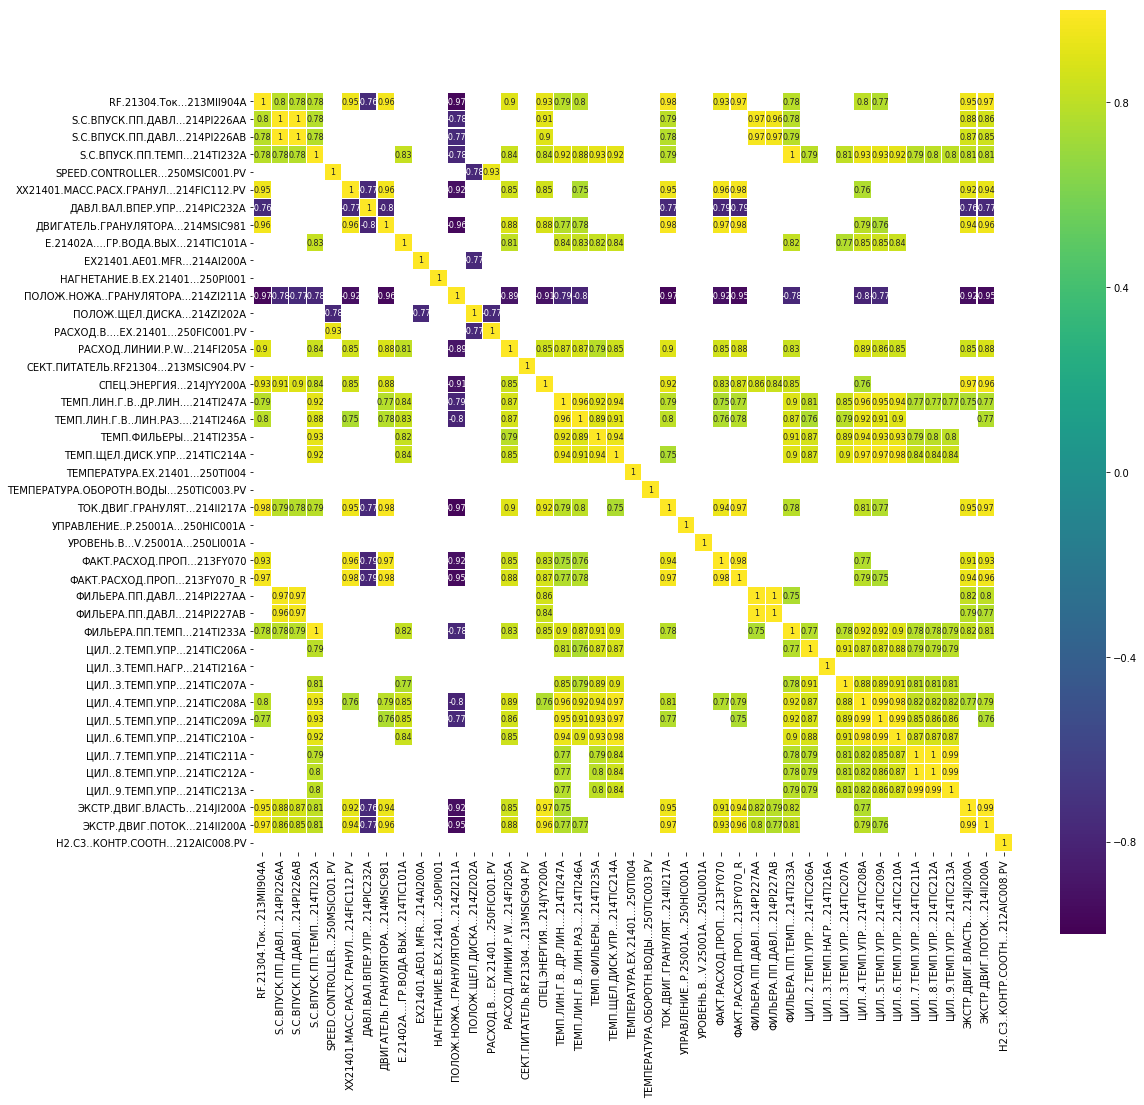

In [50]:
plt.figure(figsize=(17, 17))
sns.heatmap(corr[(corr >= 0.75) | (corr <= -0.75)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [5]:
cols = pd.read_excel('dataset/columns.xlsx')
cols.head()

,Description,Engineering Units,Comment
TP.02.01.01.T1Z.00.0.212AIC008.P,[3] ПП. Установка полимеризации. Соотношение ...,мол.%,NaN
TP.02.02.01.T1I.00.0.213MII904A.P,[3] ПП. Установка экструзии. Ток на секторном ...,A,NaN
TP.02.02.05.T1P.00.0.214PI226AA.P,[3] ПП. Установка экструзии. Давление расплава...,МПа,NaN
TP.02.02.05.T1P.00.0.214PI226AB.P,[3] ПП. Установка экструзии. Давление расплава...,МПа,NaN
TP.02.02.06.T1T.00.0.214TI232A.P,[3] ПП. Установка экструзии. Температура полип...,°C,NaN


In [51]:
for d in cols.Description:
    print(d)

[3] ПП. Установка полимеризации.  Соотношение Н2/С3  в R-21201
[3] ПП. Установка экструзии. Ток на секторном питателе RF-21304
[3] ПП. Установка экструзии. Давление расплава до сит ЕХ-21401
[3] ПП. Установка экструзии. Давление расплава до сит ЕХ-21401
[3] ПП. Установка экструзии. Температура полипропилена перед сеткой фильтром
[3] ПП. Установка экструзии. Частота P-25001A
[3] ПП. Установка экструзии. Расход гранул полипропилена
[3] ПП. Установка экструзии. Давление впереди вала
[3] ПП. Установка экструзии. Частота вращения мотора EX21401-M03
[3] ПП. Установка экструзии.  Температура охлаждающей воды на выходе из охладителя (Е-21402А ГР/ВОДА ВЫХ)
[3] ПП. Установка экструзии. Показатель текучести расплава полимера (ЕХ21401-АЕ01 MFR)
[3] ПП. Установка экструзии. Давление в EX-21401
[3] ПП. Установка экструзии. Датчик положения ножа экструдера
[3] ПП. Установка экструзии. Положение диска
[3] ПП. Установка экструзии. Расход в EX-21401
[3] ПП. Установка экструзии. Расход воды в E-21402
[3] 

In [37]:
data.columns[7]

'ДАВЛ.ВАЛ.ВПЕР.УПР...214PIC232A'

In [8]:
for row in cols.iterrows():
    if 'Ток' in row[1].Description:
        print(row[1].Description)

[3] ПП. Установка экструзии. Ток на секторном питателе RF-21304
[3] ПП. Установка экструзии.  Ток ЕХ-21401-М01


In [ ]:
data.

In [3]:
pd.read_csv('dataset/stops.csv')

,date,type
0,11.1.17 11:03,stop
1,30.1.17 8:51,stop
2,24.2.17 17:45,stop
3,7.3.17 0:16,stop
4,8.3.17 11:23,vibrosito
5,8.3.17 15:56,vibrosito
6,10.3.17 17:55,stop
7,31.3.17 1:42,vibrosito
8,1.4.17 7:45,stop
9,3.4.17 20:48,stop
